In [411]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import SocialDistancingStudents

In [412]:
sns.set_context("paper")
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Data Loading

In [413]:
# Load dataset
dataset = SocialDistancingStudents()
data = dataset.data

In [414]:
# Load additional data
print(f'Reading {dataset.raw_paths[2]}')
tweets_df = pd.read_parquet(dataset.raw_paths[2], engine='pyarrow', use_nullable_dtypes=True)
tweets_df = tweets_df.set_index('id').sort_index()
tweets_df['timestamp_from'] = pd.to_datetime(tweets_df.timestamp_from, unit='s')
tweets_df.head(10)

Reading /data/pella/projects/University/Thesis/Thesis/source/storage/cache/dataset/social-distancing-student/raw/node__Tweet


tid                                               name  \
id                                                                           
0   1311425852169744385  @NUnl Waarom niet de dove mens het mondkapje o...   
1   1311426330488180736  hoe meer werklozen er komen. Hoe meer bedrijve...   
2   1311426383906844672  RT @Rijksoverheid: Dringend advies: draag vana...   
3   1311426584893624322  RT @natassavass: George Soros in de bocht! Pom...   
4   1311426630020202498  RT @Zuidplas: Dringend advies: draag vanaf van...   
5   1311426978390716417  RT @VRgroningen: Dringend advies: draag vanaf ...   
6   1311427296105029633  Van Dissel: thuis blijven bij klachten en afst...   
7   1311427312328609797  @mkeulemans @LarsNos Ik denk nog steeds dat ze...   
8   1311428045161590786  RT @MinVWS: Dringend advies: draag vanaf vanda...   
9   1311428230235271168  RT @MinVWS: Dringend advies: draag vanaf vanda...   

   label_social_distancing  feat_supports  feat_irrelevant  feat_rejects  \
id                                                                         
0                 SUPPORTS       0.982131         0.014853      0.003045   
1                 SUPPORTS       0.902437         0.000080      0.097513   
2                 SUPPORTS       1.000010         0.000010      0.000010   
3                 SUPPORTS       0.997979         0.002040      0.000010   
4                 SUPPORTS       1.000010         0.000010      0.000010   
5                 SUPPORTS       1.000010         0.000010      0.000010   
6                 SUPPORTS       1.000005         0.000015      0.000010   
7                 SUPPORTS       0.954173         0.024684      0.021173   
8                 SUPPORTS       1.000010         0.000010      0.000010   
9                 SUPPORTS       1.000010         0.000010      0.000010   

    feat_sentiment      timestamp_from  
id                                      
0             -0.6 2020-09-30 20:01:02  
1             -0.6 2020-09-30 20:02:56  
2             -0.6 2020-09-30 20:03:09  
3             -0.6 2020-09-30 20:03:57  
4             -0.6 2020-09-30 20:04:08  
5             -0.6 2020-09-30 20:05:31  
6             -0.6 2020-09-30 20:06:47  
7             -0.6 2020-09-30 20:06:51  
8             -0.6 2020-09-30 20:09:45  
9             -0.6 2020-09-30 20:10:29

In [415]:
# Ensure graph node order mathces loaded data
assert (data['Tweet'].name[:10] == tweets_df['name'].iloc[:10].values).all()

In [416]:
label = (tweets_df['label_social_distancing'] == 'SUPPORTS').map(int).values

In [417]:
# Load embeddings
Z_dict = torch.load('ac_embeddings_hetero_.pt')
# Z_dict = torch.load('ac_embeddings_hetero.pt')

In [418]:
att = torch.load('ac_att.pt')

# Overall Statistics

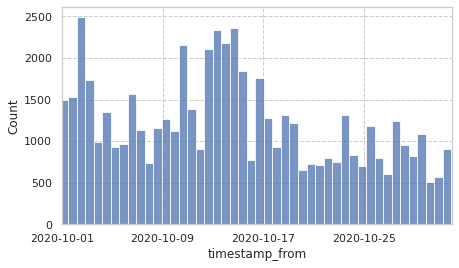

In [419]:
import matplotlib.ticker as ticker

g = sns.histplot(tweets_df, x='timestamp_from')
g.set_xlim(tweets_df.timestamp_from.dt.round('d').min(), tweets_df.timestamp_from.dt.round('d').max())
g.xaxis.set_major_locator(ticker.MultipleLocator(8))
plt.savefig('figs/case_study/01_timestamp_dist.pdf', bbox_inches='tight')

# Attention Visualization

In [420]:
from ml.utils import dict_mapv, dict_catv

att_topo_dict = dict_mapv(att['Att_topo'], lambda x: x.mean(0))
att_topo = dict_catv(att['Att_topo']).mean(0)

att_tempo_dict = dict_mapv(att['Att_tempo'], lambda x: x.mean(0))
att_tempo = dict_catv(att['Att_tempo']).mean(0)

att_norm = torch.stack([att_topo, att_tempo]).sum(0)

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


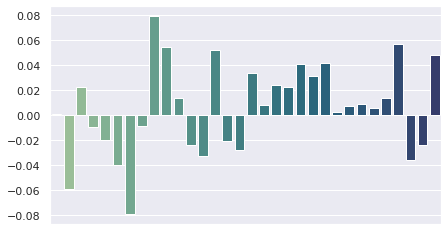

In [421]:
sns.set(rc={'figure.figsize':(7,4)})
g = sns.barplot(
    list(range(len(att_topo))),
    (att_topo - att_tempo).numpy(),
    palette='crest',
)
g.set(xticklabels=[])
g.set(xlabel=None)
plt.savefig('figs/case_study/02_att_topo_v_tempo.pdf', bbox_inches='tight')

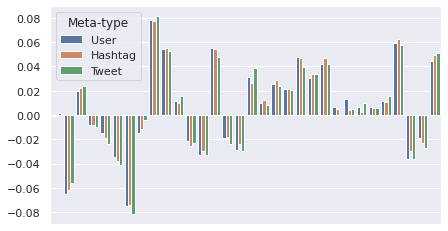

In [422]:
df = pd.DataFrame({
    'x': list(range(len(att_topo))),
    **dict_mapv(att_topo_dict, lambda x: 2 * (x / att_norm - 0.5).numpy()),
}).melt('x', var_name='Meta-type', value_name='value', value_vars=['User', 'Hashtag', 'Tweet'])

sns.set(rc={'figure.figsize':(7,4)})
g = sns.barplot(
    data=df,
    x='x', y='value', hue='Meta-type',
    palette='deep',
)
g.set(xticklabels=[])
g.set(xlabel=None)
g.set(ylabel=None)
plt.savefig('figs/case_study/03_att_topo_v_tempo_type.pdf', bbox_inches='tight')

# Attention Items

In [423]:
from collections import Counter
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
stopwords = stopwords.words('dutch')

def clean_tweets(corpus):
    corpus = re.sub("@[A-Za-z0-9]+","",corpus) #Remove @ sign
    corpus = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", corpus) #Remove http links
    # corpus = ''.join(c for c in corpus if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    corpus = corpus.replace("#", "").replace("_", " ")
    corpus = re.sub("[^a-z0-9]"," ", corpus)
    return corpus


wc = Counter(clean_tweets(' '.join(tweets_df.name)).split())
most_common = wc.most_common(200)
most_common = list(map(lambda x: x[0], most_common))
# print(most_common)

def tweets(feat_i, k=100):
    item_idx = torch.argsort(Z_dict['Tweet'][:, feat_i], descending=True)
    df = tweets_df.iloc[item_idx[:k]]
    corpus = ' '.join(df.name).lower()
    return clean_tweets(corpus)

def wordcloud(corpus, ax=None, feat_i=None):
    wordcloud = WordCloud(random_state = 8,
        normalize_plurals = False,
        width = 600, height= 600,
        max_words = 300,
        background_color="white",
        stopwords = [
            *stopwords,
            'afstand', 'meter', 'elkaar', 'houden', 'tussen', 'max', 'hou', 'houd', 'alleen', 'jij', 'we', 'wel', 'houdt', '5m',
            'rt', 'm', 'p', 'i', 'ee', 'jullie', 'zie', 'zit', #, 'anderhalve', 'mensen', 'mondkapje', 'mondkapjes',
            *most_common,
        ])
    wordcloud.generate(corpus)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.grid(b=None)
    ax.set_title('Feature {}'.format(feat_i))

def hashtags(feat_i, k=10):
    item_idx = torch.argsort(Z_dict['Hashtag'][:, feat_i], descending=True)
    hashtag_df = pd.DataFrame({
        'top': data['Hashtag'].name[item_idx[:k]],
        'bottom': data['Hashtag'].name[item_idx[-k:]],
    })
    return hashtag_df

## Topological Attention

In [424]:
print(f'Most important feature {att_topo.argmax()} from {att_topo.shape}')
topo_feat_best = att_topo.argmax()

Most important feature 19 from torch.Size([32])


/tmp/ipykernel_11849/385540276.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


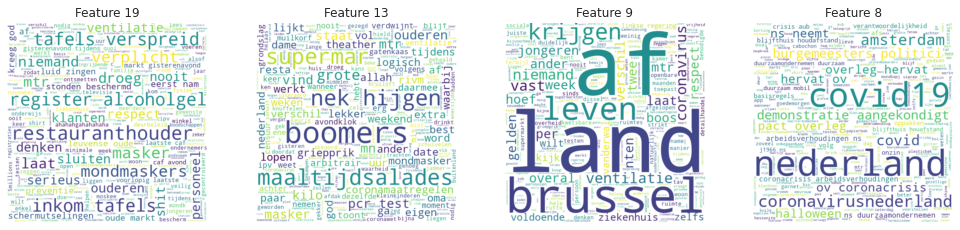

In [425]:
# fig, axes = plt.subplots(2,4, figsize=(14,8))
fig, axes = plt.subplots(1,4, figsize=(14,4))
fig.tight_layout()
# for i, feat_i in enumerate(torch.argsort(att_topo, descending=True)[:8]):
for i, feat_i in enumerate(torch.argsort(att_topo, descending=True)[:4]):
    wordcloud(tweets(feat_i), ax=axes[i % 4], feat_i=feat_i)
plt.savefig('figs/case_study/04_att_topo_cloud.pdf', bbox_inches='tight')

In [426]:
for i, feat_i in enumerate(torch.argsort(att_topo, descending=True)[:4]):
    print('Feature {}'.format(feat_i))
    display(hashtags(feat_i))

Feature 19


top              bottom
0             mondkapje              bubbel
1             Halloween           Malieveld
2       anderhalvemeter           cursussen
3            mondkapjes             bewegen
4                corona              gezond
5     coronamaatregelen  toegangsspecialist
6               vivaldi     Gezondheidszorg
7              lockdown    Follow_the_money
8               coroNEE      CaféOudBrabant
9  professioneelvoetbal              rkcfey

Feature 13


top            bottom
0        Verkiezingen              film
1          arrogantie               url
2    incubatieperiode     Voorleeslunch
3     LouisHartlooper        neemeenkar
4      haarlemmermeer   Sinterklaasfilm
5               LHCnl  MijnMorgenMuziek
6  binnenandereregels       Drachenfels
7                 LHC          Giro2020
8       onbetrouwbaar      bleibegesund
9            delanwel              mose

Feature 9


top            bottom
0   Ouderenuurtje            corona
1  openbareruimte  mondkapjesplicht
2       papierbak        scholieren
3             LHC   persconferentie
4   FakeNewsMedia     scholenveilig
5   rekenbootcamp          lockdown
6       cursussen         aboutaleb
7         actrice             Sneek
8          Occupy         Toverland
9              vo         mondkapje

Feature 8


top               bottom
0         mondkapjes             Bolsward
1    anderhalvemeter  hetisnietzomoeilijk
2        coronavirus          SheepNoMore
3      viruswaarheid  anitawordtopgenomen
4            Covid19          longhaulers
5             corona        Voorleeslunch
6       coronacrisis          wnlopzondag
7  coronamaatregelen             CLLoting
8             Corona          Wasjehanden
9            coroNEE               winwin

## Temporal Attention

In [427]:
print(f'Most important feature {att_tempo.argmax()} from {att_tempo.shape}')
feat_best = att_tempo.argmax()

Most important feature 6 from torch.Size([32])


In [428]:
def visualize_tempo_hist(feature_i, k=400, ax=None):
    item_idx = torch.argsort(Z_dict['Tweet'][:, feature_i], descending=True)
    df = tweets_df.iloc[item_idx[:k]]
    df['timestamp_from'] = df.timestamp_from.dt.round('d')

    g = sns.histplot(df, x='timestamp_from', bins=32, ax=ax)
    g.set_xlim(tweets_df.timestamp_from.dt.round('d').min(), tweets_df.timestamp_from.dt.round('d').max())
    g.xaxis.set_major_locator(ticker.MultipleLocator(10))
    g.set_title('Feature {}'.format(feature_i))
    g.set_xlabel('Timestamp')
    return g

/tmp/ipykernel_11849/3169036796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/3169036796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/3169036796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

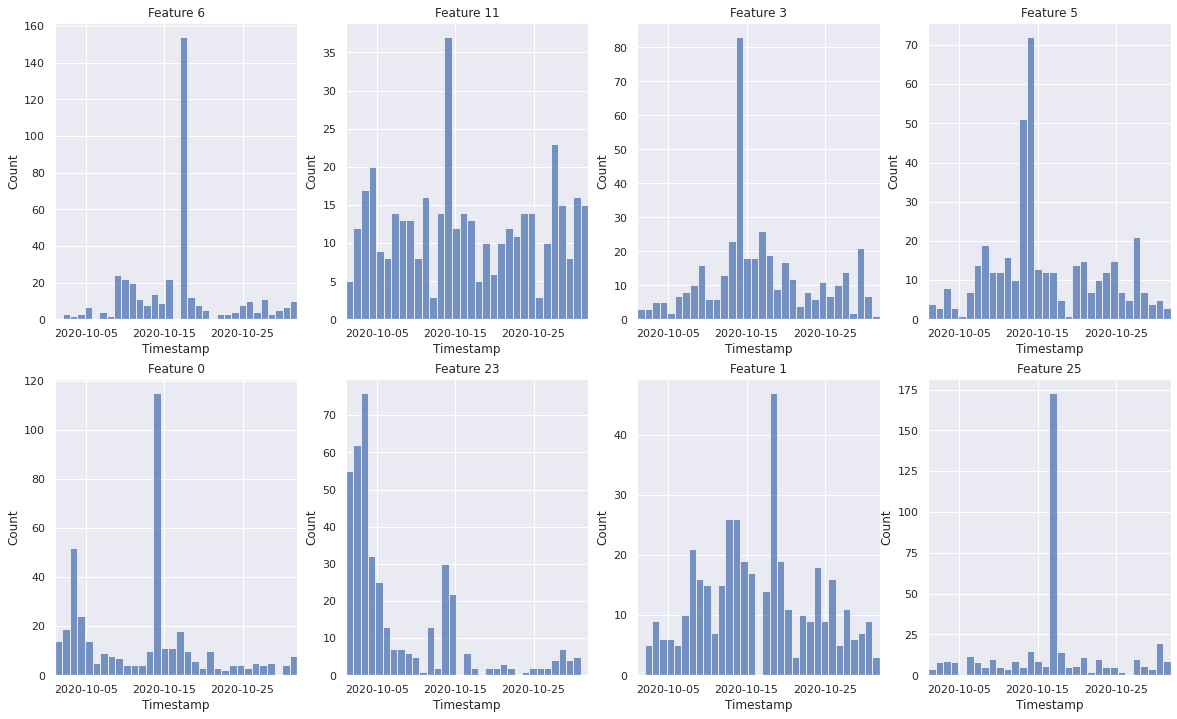

In [429]:
fig, axes = plt.subplots(2,4, figsize=(20,12))
for i, feat_i in enumerate(torch.argsort(att_tempo, descending=True)[[0, 1, 2, 3, 4, 5, 6, 9]]):
    visualize_tempo_hist(feat_i, ax=axes[i // 4, i % 4])
plt.savefig('figs/case_study/05_att_tempo_hist.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_11849/385540276.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


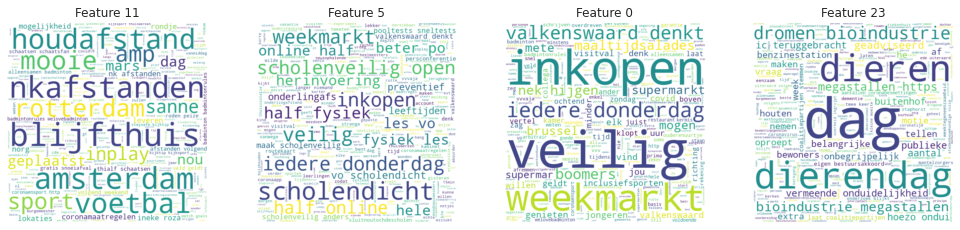

In [430]:
# fig, axes = plt.subplots(2,4, figsize=(14,8))
fig, axes = plt.subplots(1,4, figsize=(14,4))
fig.tight_layout()
# for i, feat_i in enumerate(torch.argsort(att_tempo, descending=True)[[0, 1, 2, 3, 4, 5, 6, 9]]):
for i, feat_i in enumerate(torch.argsort(att_tempo, descending=True)[[1, 3, 4, 5]]):
    wordcloud(tweets(feat_i), ax=axes[i % 4], feat_i=feat_i)
plt.savefig('figs/case_study/06_att_tempo_cloud.pdf', bbox_inches='tight')

In [451]:
for i, feat_i in enumerate(torch.argsort(att_tempo, descending=True)[[1, 3, 4, 5]]):
    item_idx = torch.argsort(Z_dict['Tweet'][:, feat_i], descending=True)
    df = tweets_df.iloc[item_idx[:40]]
    print('========================================================')
    print('Feature {}'.format(feat_i))
    for row in df.itertuples():
        print(row.name)

Feature 11
Olympische spelen 2020: 1.5m stickers. Ze zouden moeten voorkomen dat men de regels negeert #os2020 #stickers #beetjeshelpen #amsterdam
🚨⚽🚨⚽

Inplay Tip 👇

Skive v Vendsyssel FF ⚽

Over 1.5 Match Goals 💰

#inplay #livebet #inplaychallenge #LIVEBETTING… https://t.co/snc9GqZahJ
RT @TeamPalet: Ineke, Roza en Sanne hebben zich geplaatst voor  NK Afstanden volgend weekend in Thialf #schaatsen #schaatsfan #nkafstanden…
Bet 1 
FINLAND 
Kerho 07 v MyPa Myllykoski
 1st half | 32:01 min | 1 - 0

Over 1.5 Match goals 
Price @ 1.90 

20 &gt;&gt;&gt; 38
  #betway
RT @rayklaassen: ANDERHALVE METER SESSIES

Boek een #anderhalve #meter #sessie voor jouw #geliefde #jarige #moeder #vader #ouders #oma #opa…
ANDERHALVE METER SESSIES

Boek een #anderhalve #meter #sessie voor jouw #geliefde #jarige #moeder #vader #ouders… https://t.co/aTPvnU0dMn
Ineke, Roza en Sanne hebben zich geplaatst voor  NK Afstanden volgend weekend in Thialf #schaatsen #schaatsfan… https://t.co/T2SEE4TDJe
Mooie tweede dag 

In [456]:
torch.unique(torch.from_numpy(label), return_counts=True)

(tensor([0, 1]), tensor([11823, 44350]))

# Embedding Visualization

In [431]:
import umap
import numba

In [432]:
@numba.njit()
def dotp_dist(a, b):
    return -(a * b).sum()

In [433]:
# reducer = umap.UMAP(metric='cosine')
reducer = umap.UMAP(metric=dotp_dist)
embedding = reducer.fit_transform(Z_dict['Tweet'])
embedding.shape

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


(56173, 2)

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_11849/372439762.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figs/case_study/07_embedding_sentiment.pdf', bbox_inches='tight', rasterized=True)


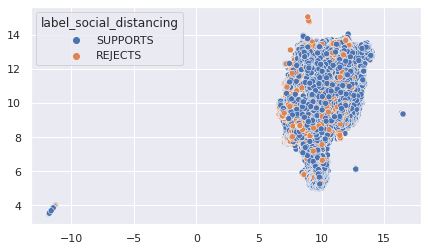

In [434]:
sns.scatterplot(embedding[:, 0], embedding[:, 1], hue=tweets_df['label_social_distancing'], palette='deep')
plt.savefig('figs/case_study/07_embedding_sentiment.pdf', bbox_inches='tight', rasterized=True)

In [435]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

X_new = SelectKBest(mutual_info_classif, k=2).fit_transform(Z_dict['Tweet'],label)

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_11849/4291292897.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figs/case_study/08_embedding_sentiment_best.png', bbox_inches='tight', rasterized=True)


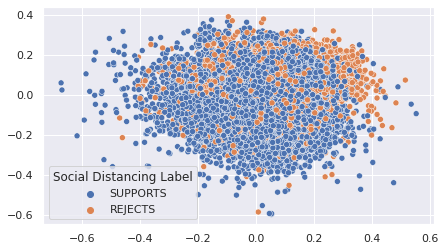

In [436]:
g = sns.scatterplot(X_new[:, 0], X_new[:, 1], hue=tweets_df['label_social_distancing'], palette='deep')
g.legend(title='Social Distancing Label')
plt.savefig('figs/case_study/08_embedding_sentiment_best.png', bbox_inches='tight', rasterized=True)

# Cluster Quality

In [437]:
z_dict = torch.load('ac_z.pt')
z = z_dict['Tweet']

In [438]:
def visualize_cluster_hist(feature_i, ax=None):
    df = tweets_df.iloc[(z == feature_i).nonzero().flatten()]
    df['timestamp_from'] = df.timestamp_from.dt.round('d')

    g = sns.histplot(df, x='timestamp_from', bins=32, ax=ax)
    g.set_xlim(tweets_df.timestamp_from.dt.round('d').min(), tweets_df.timestamp_from.dt.round('d').max())
    g.xaxis.set_major_locator(ticker.MultipleLocator(10))
    g.set_title('Cluster {}'.format(feature_i))
    g.set_xlabel('Timestamp')
    return g

/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

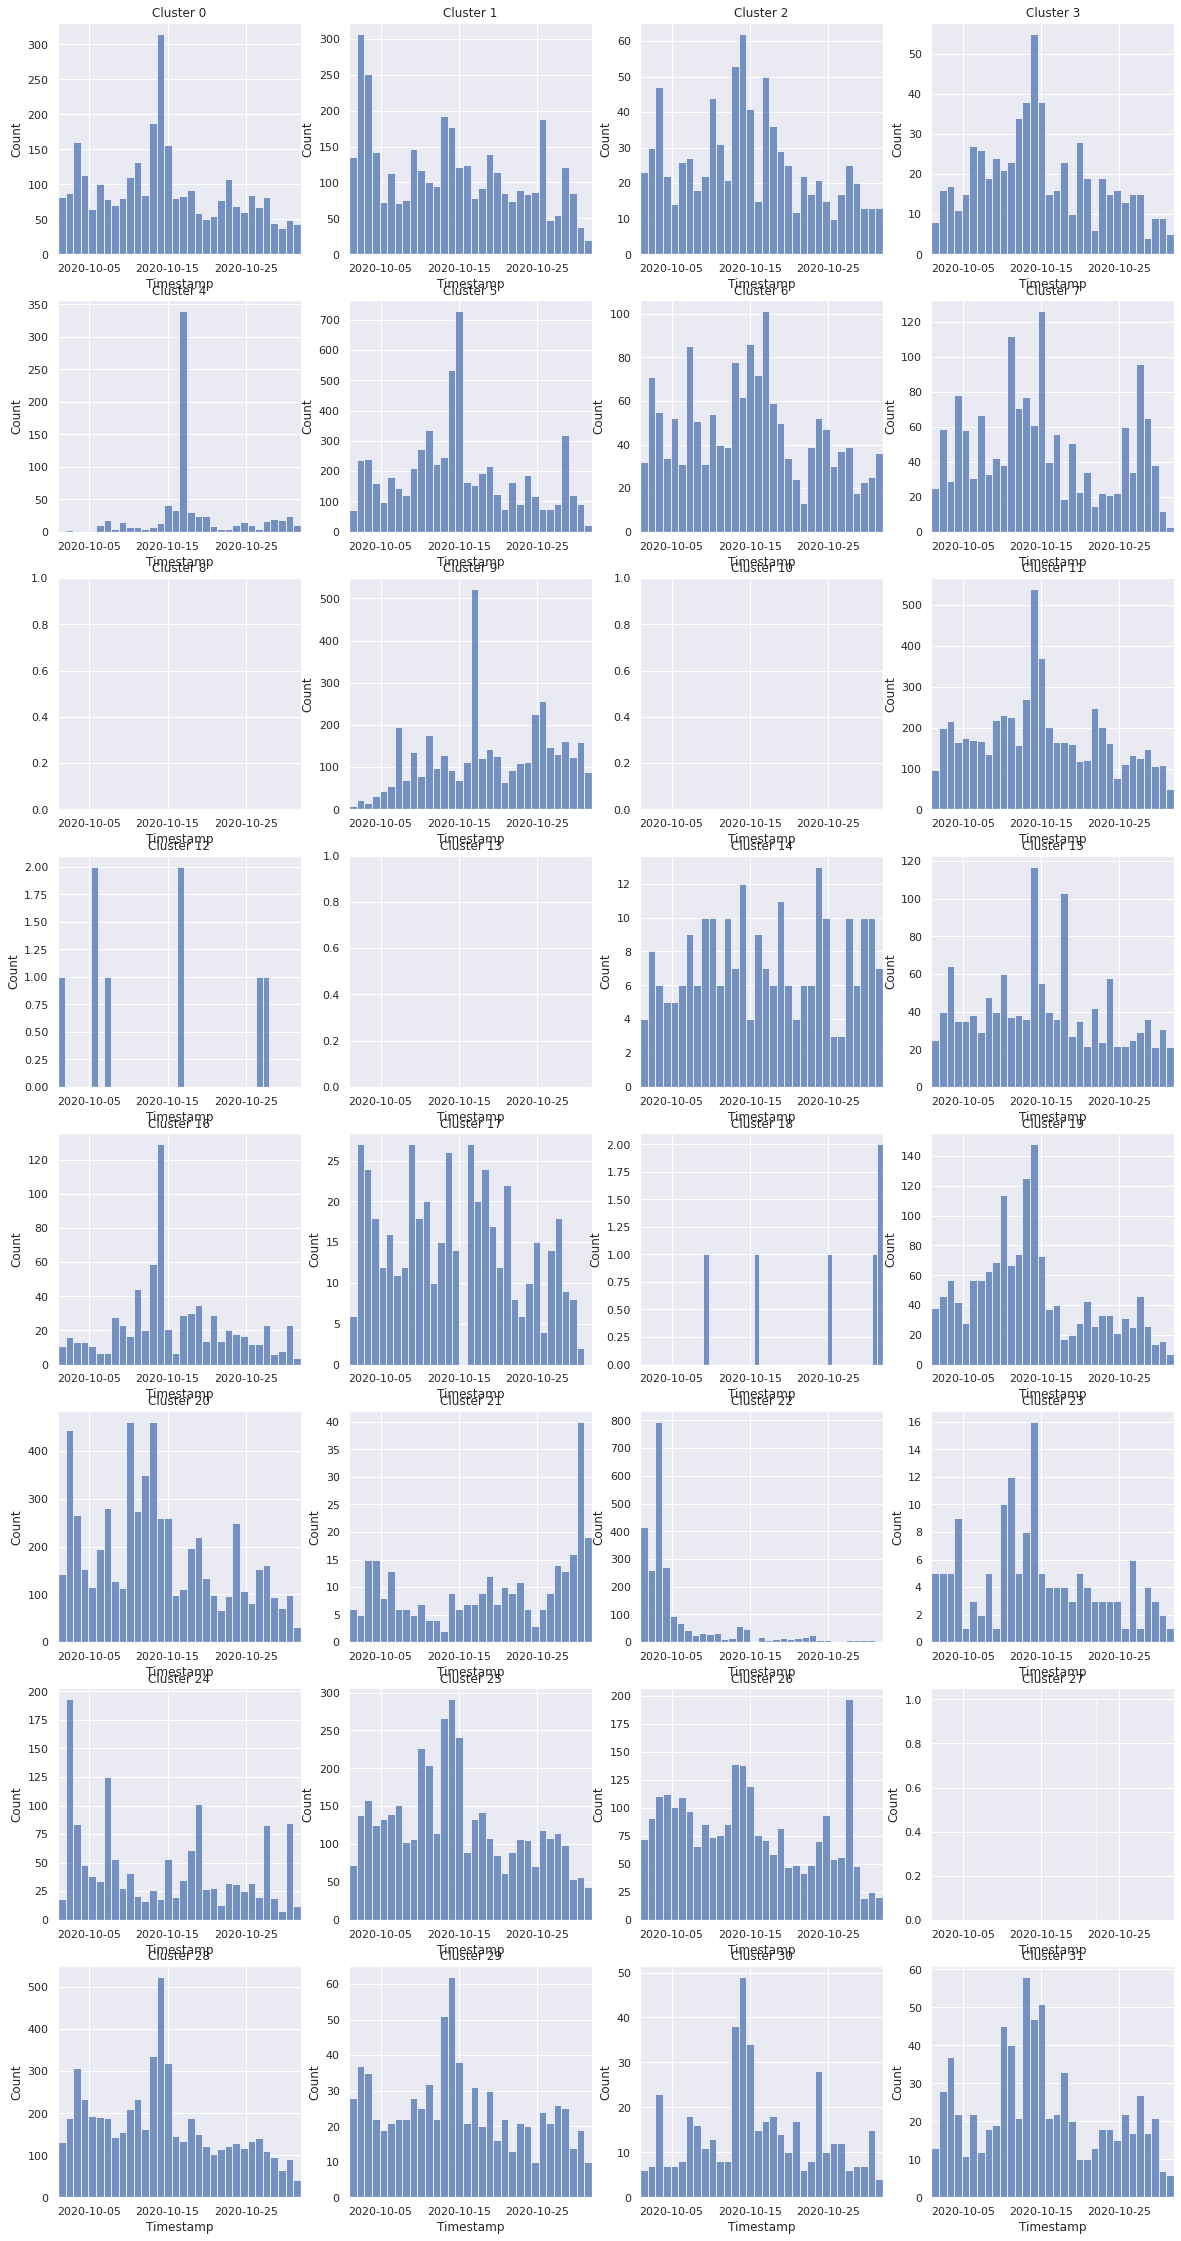

In [439]:
fig, axes = plt.subplots(8,4, figsize=(20,40))
for i, feat_i in enumerate(range(32)):
    visualize_cluster_hist(feat_i, ax=axes[i // 4, i % 4])
plt.show()

/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_from'] = df.timestamp_from.dt.round('d')
/tmp/ipykernel_11849/1597539317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

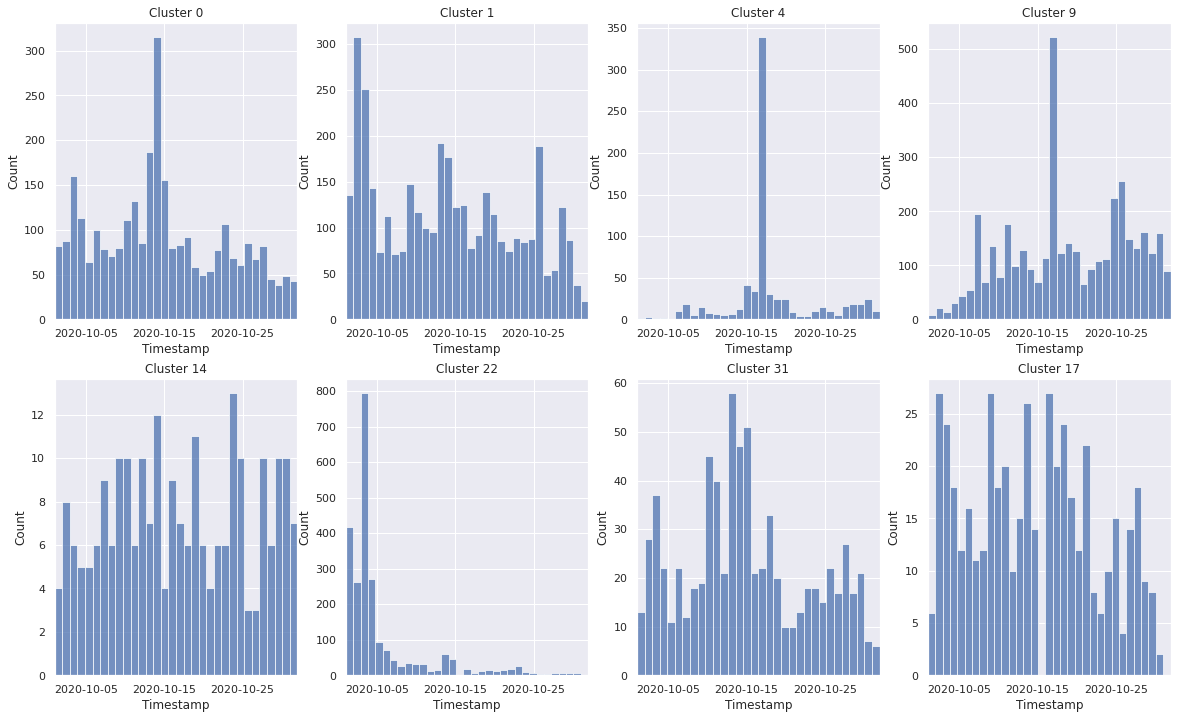

In [440]:
fig, axes = plt.subplots(2,4, figsize=(20,12))
for i, feat_i in enumerate([0, 1, 4, 9, 14, 22, 31, 17]):
    visualize_cluster_hist(feat_i, ax=axes[i // 4, i % 4])
plt.savefig('figs/case_study/09_cluster_timestamp_dist.pdf', bbox_inches='tight')

In [441]:
import itertools as it

df = pd.DataFrame({
    'label': dict_catv(z_dict),
    'type': list(it.chain(*[
        [ty] * len(zt)
        for ty, zt in z_dict.items()
    ]))
})
df.head()

label  type
0     16  User
1     23  User
2     12  User
3     12  User
4     16  User

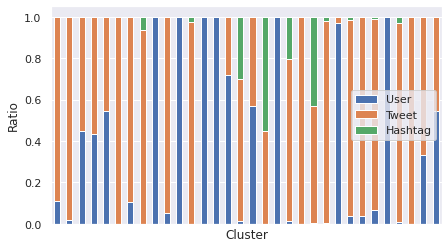

<Figure size 648x216 with 0 Axes>

In [442]:
dfg = df.groupby(['label', 'type']).size().reset_index().rename(columns={0: 'count'})\
    .pivot_table(index='label', columns='type', values='count').fillna(0)
dfg['count'] = dfg['Hashtag'] + dfg['User'] + dfg['Tweet']
dfg['Tweet'] /= dfg['count']
dfg['Hashtag'] /= dfg['count']
dfg['User'] /= dfg['count']


ax = dfg[['User', 'Tweet', 'Hashtag']].plot(kind='bar', stacked=True, xlabel='Cluster', ylabel='Ratio')
fig=ax.get_figure()
plt.xticks([], [])
plt.legend(loc='center right')
plt.figure(figsize=(9,3))
fig.savefig('figs/case_study/10_cluster_type_dist.pdf', bbox_inches='tight')

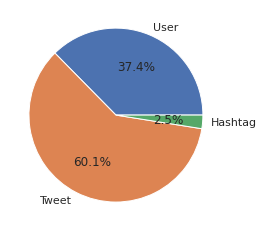

<Figure size 360x288 with 0 Axes>

In [443]:
ax = df.groupby('type').size().sort_index(ascending=False).plot(kind='pie', autopct='%1.1f%%')
fig=ax.get_figure()
plt.ylabel('')
plt.figure(figsize=(5,4))
fig.savefig('figs/case_study/11_global_type_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_11849/385540276.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


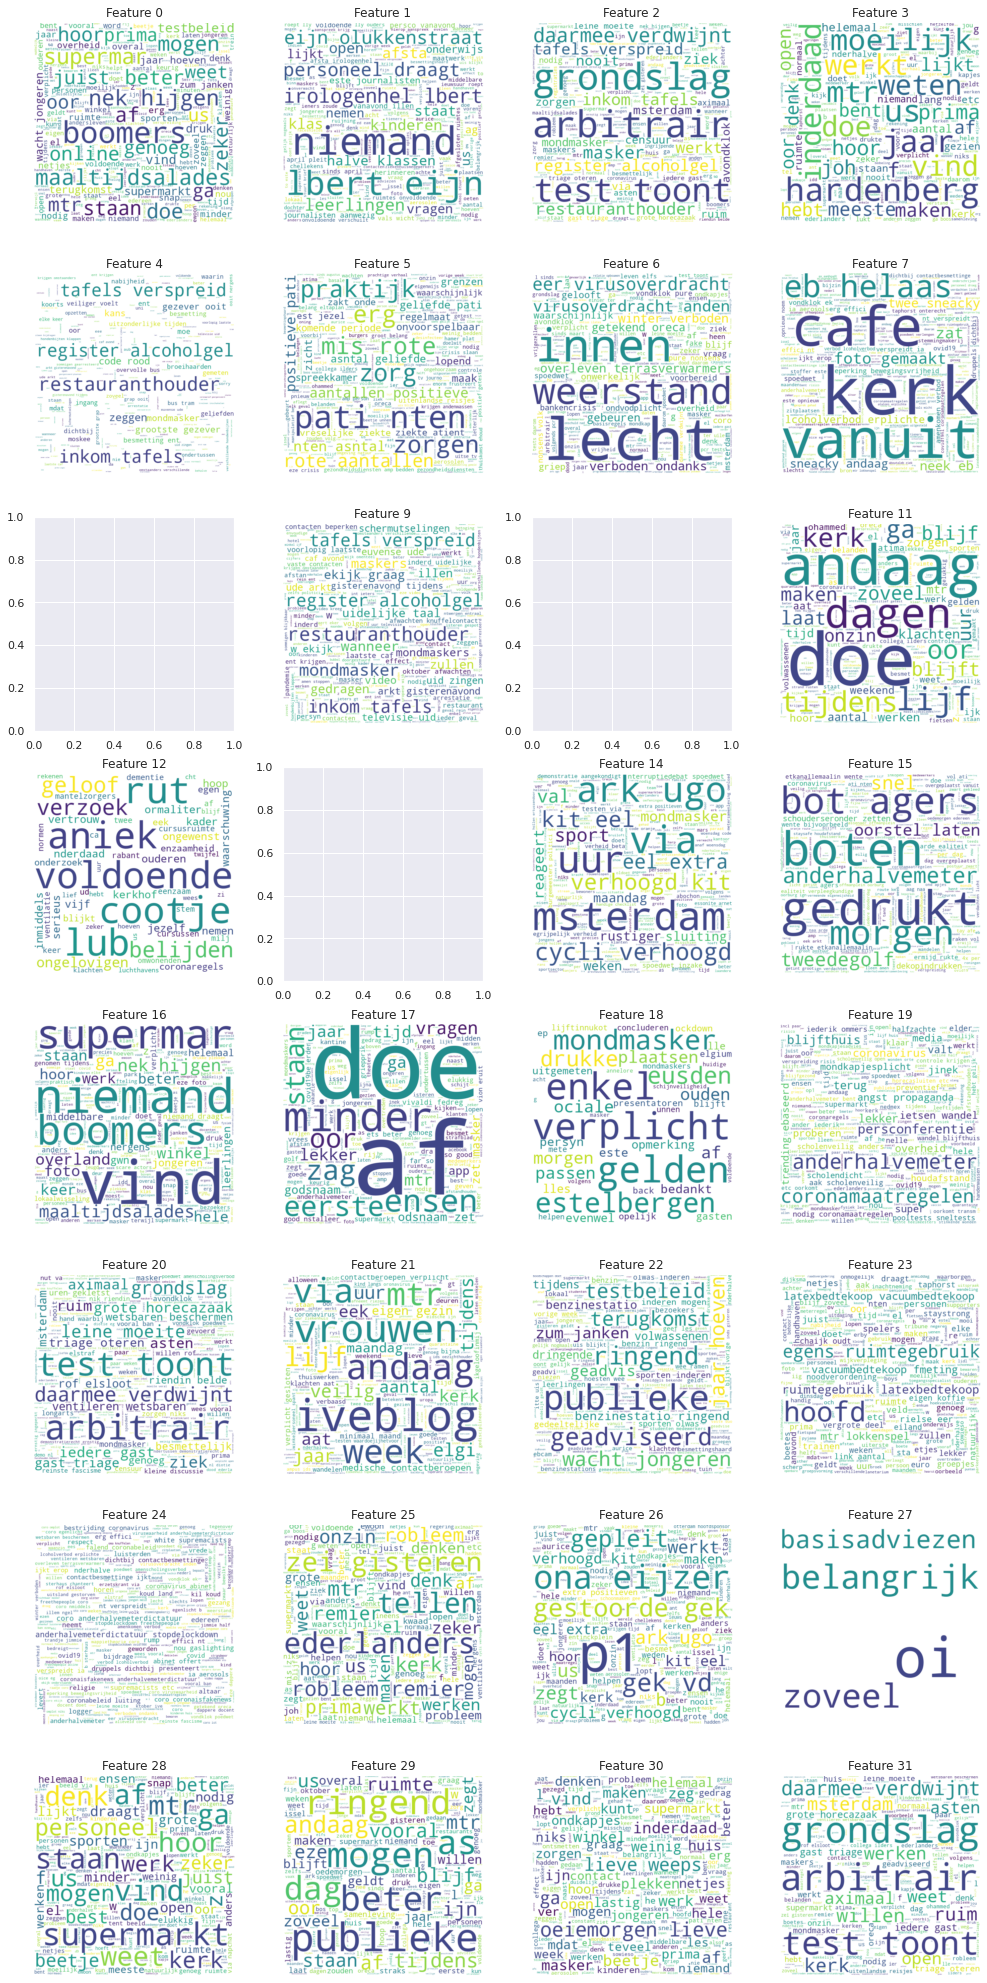

In [444]:
fig, axes = plt.subplots(8,4, figsize=(14,28))
fig.tight_layout()
for i, feat_i in enumerate(range(32)):
    df = tweets_df.iloc[(z == feat_i).nonzero().flatten()]
    try:
        wordcloud(clean_tweets(' '.join(df.name)), ax=axes[i // 4, i % 4], feat_i=feat_i)
    except Exception:
        pass

/tmp/ipykernel_11849/385540276.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


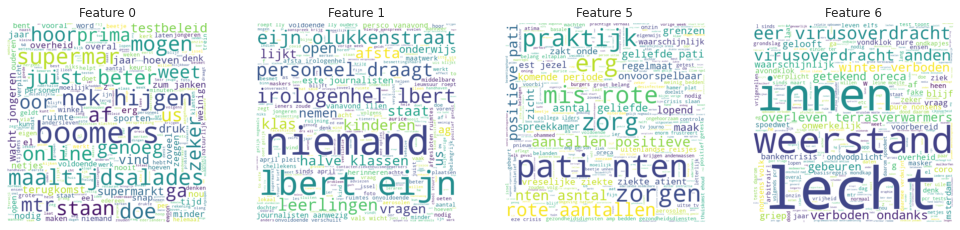

In [445]:
fig, axes = plt.subplots(1,4, figsize=(14,7))
fig.tight_layout()
for i, feat_i in enumerate([0, 1, 5, 6]):
    df = tweets_df.iloc[(z == feat_i).nonzero().flatten()]
    try:
        wordcloud(clean_tweets(' '.join(df.name)), ax=axes[i % 4], feat_i=feat_i)
    except Exception as e:
        print(e)
plt.savefig('figs/case_study/12_cluster_cloud.pdf', bbox_inches='tight')